# Question 1: Christ University Central Block Grid-World

**Student ID:** 2448540  
**Course:** Reinforcement Learning  
**Total Marks:** 25

---

## Problem Statement

A navigational agent must traverse the Christ University Central Block represented as a 3×3 Grid-World. The objective is to move from the **Ground Floor Entrance** at state $(0,0)$ to the **Exam Control Room** located at state $(2,2)$. The agent receives a reward of **-1** for each step taken and a terminal reward of **+10** upon reaching the goal state. This formulation encourages the agent to discover the shortest path to minimize cumulative negative rewards while maximizing the final goal reward.

In [1]:
# Standard library imports for the entire notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
import pandas as pd

# Configuration for publication-quality figures
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
sns.set_style('whitegrid')

---

## 1. Environment Representation (8 Marks)

### Grid-World Formalization

The environment is formalized as a Markov Decision Process (MDP) with the following components:

| Component | Specification |
|-----------|---------------|
| **State Space** $\mathcal{S}$ | $\{(i, j) : i, j \in \{0, 1, 2\}\}$, yielding 9 discrete states |
| **Action Space** $\mathcal{A}$ | $\{\text{UP}, \text{DOWN}, \text{LEFT}, \text{RIGHT}\}$ |
| **Start State** $s_0$ | $(0, 0)$ — Ground Floor Entrance |
| **Goal State** $s_g$ | $(2, 2)$ — Exam Control Room |
| **Step Reward** | $R_{step} = -1$ |
| **Goal Reward** | $R_{goal} = +10$ |
| **Transition Dynamics** | Deterministic; boundary collisions result in no state change |

The coordinate system follows matrix indexing where $(0,0)$ represents the bottom-left corner (row 0, column 0) and $(2,2)$ represents the top-right corner of the grid.

In [2]:
class GridWorld:
    """
    A 3x3 Grid-World environment representing the Christ University Central Block.
    
    The agent navigates from the Ground Floor Entrance (0,0) to the Exam Control Room (2,2).
    Transition dynamics are deterministic with boundary constraints.
    """
    
    # Action encoding follows standard convention: 0=UP, 1=DOWN, 2=LEFT, 3=RIGHT
    ACTIONS = {'UP': 0, 'DOWN': 1, 'LEFT': 2, 'RIGHT': 3}
    ACTION_NAMES = {0: 'UP', 1: 'DOWN', 2: 'LEFT', 3: 'RIGHT'}
    
    # Movement vectors corresponding to each action
    # UP increases row index (moving up visually), DOWN decreases it
    ACTION_DELTAS = {
        0: (1, 0),   # UP: increase row
        1: (-1, 0),  # DOWN: decrease row
        2: (0, -1),  # LEFT: decrease column
        3: (0, 1)    # RIGHT: increase column
    }
    
    def __init__(self, grid_size=3):
        self.grid_size = grid_size
        self.start_state = (0, 0)
        self.goal_state = (2, 2)
        self.current_state = self.start_state
        
        # Reward structure: penalize each step to encourage efficiency
        self.step_reward = -1
        self.goal_reward = 10
        
    def reset(self):
        """Reset the agent to the start state at the beginning of each episode."""
        self.current_state = self.start_state
        return self.current_state
    
    def is_valid_state(self, state):
        """Verify that a state lies within grid boundaries."""
        row, col = state
        return 0 <= row < self.grid_size and 0 <= col < self.grid_size
    
    def step(self, action):
        """
        Execute an action and return the resulting transition tuple.
        
        Parameters:
            action (int): Action index from {0, 1, 2, 3}
            
        Returns:
            tuple: (next_state, reward, done)
        """
        delta = self.ACTION_DELTAS[action]
        next_state = (self.current_state[0] + delta[0], 
                      self.current_state[1] + delta[1])
        
        # Boundary collision handling: agent remains in place if move is invalid
        if not self.is_valid_state(next_state):
            next_state = self.current_state
        
        self.current_state = next_state
        
        # Determine reward and terminal condition
        if next_state == self.goal_state:
            return next_state, self.goal_reward, True
        else:
            return next_state, self.step_reward, False
    
    def get_valid_actions(self, state):
        """Return list of actions that result in actual movement from given state."""
        valid = []
        for action, delta in self.ACTION_DELTAS.items():
            next_state = (state[0] + delta[0], state[1] + delta[1])
            if self.is_valid_state(next_state):
                valid.append(action)
        return valid


# Instantiate the environment for subsequent use
env = GridWorld()
print(f"Grid-World Environment Initialized")
print(f"  State Space: {env.grid_size}x{env.grid_size} = {env.grid_size**2} states")
print(f"  Start State: {env.start_state} (Ground Floor Entrance)")
print(f"  Goal State: {env.goal_state} (Exam Control Room)")
print(f"  Step Reward: {env.step_reward}")
print(f"  Goal Reward: {env.goal_reward}")

Grid-World Environment Initialized
  State Space: 3x3 = 9 states
  Start State: (0, 0) (Ground Floor Entrance)
  Goal State: (2, 2) (Exam Control Room)
  Step Reward: -1
  Goal Reward: 10


### Visual Representation of the Grid-World

The following visualization depicts the 3×3 Grid-World with:
- **Green cell**: Start state $(0,0)$ — Ground Floor Entrance
- **Red cell**: Goal state $(2,2)$ — Exam Control Room
- **Arrows**: Valid state transitions from each cell
- **Coordinate labels**: $(row, col)$ indices for each state

The visual representation aids in understanding the spatial structure of the navigation problem.

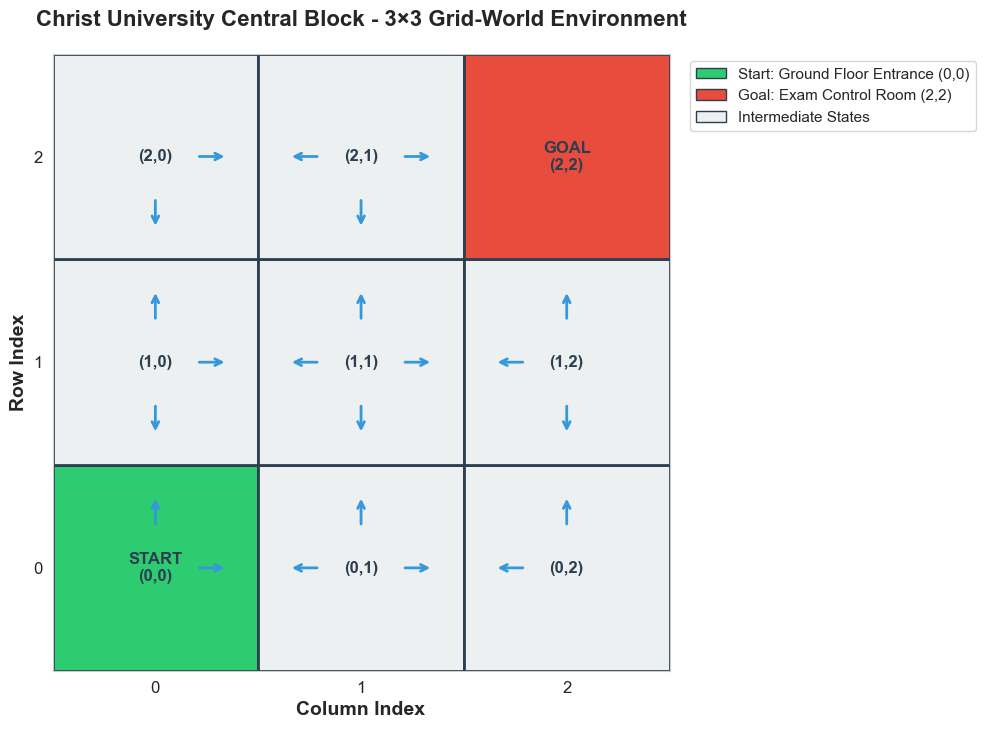

In [3]:
def visualize_gridworld(env):
    """
    Generate a comprehensive visualization of the Grid-World environment.
    
    The visualization includes color-coded start/goal states, coordinate annotations,
    and directional arrows indicating valid transitions from each state.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Color mapping for different cell types
    colors = {
        'start': '#2ecc71',    # Vibrant green for start
        'goal': '#e74c3c',     # Vibrant red for goal
        'normal': '#ecf0f1'    # Light gray for regular cells
    }
    
    # Arrow parameters for transition visualization
    arrow_params = {
        'UP': (0, 0.25),
        'DOWN': (0, -0.25),
        'LEFT': (-0.25, 0),
        'RIGHT': (0.25, 0)
    }
    
    # Draw each cell of the grid
    for row in range(env.grid_size):
        for col in range(env.grid_size):
            state = (row, col)
            
            # Determine cell color based on state type
            if state == env.start_state:
                color = colors['start']
                label = f'START\n({row},{col})'
            elif state == env.goal_state:
                color = colors['goal']
                label = f'GOAL\n({row},{col})'
            else:
                color = colors['normal']
                label = f'({row},{col})'
            
            # Create and add the cell rectangle
            rect = plt.Rectangle((col, row), 1, 1, 
                                  facecolor=color, 
                                  edgecolor='#2c3e50', 
                                  linewidth=2)
            ax.add_patch(rect)
            
            # Add state coordinate label
            ax.text(col + 0.5, row + 0.5, label, 
                    ha='center', va='center', 
                    fontsize=12, fontweight='bold',
                    color='#2c3e50')
            
            # Draw arrows for valid transitions (skip goal state - terminal)
            if state != env.goal_state:
                valid_actions = env.get_valid_actions(state)
                for action in valid_actions:
                    action_name = env.ACTION_NAMES[action]
                    dx, dy = arrow_params[action_name]
                    
                    # Position arrows at cell edges
                    start_x = col + 0.5 + dx * 0.8
                    start_y = row + 0.5 + dy * 0.8
                    
                    ax.annotate('', 
                                xy=(start_x + dx * 0.6, start_y + dy * 0.6),
                                xytext=(start_x, start_y),
                                arrowprops=dict(arrowstyle='->', 
                                               color='#3498db',
                                               lw=2))
    
    # Configure axes and labels
    ax.set_xlim(0, env.grid_size)
    ax.set_ylim(0, env.grid_size)
    ax.set_aspect('equal')
    ax.set_xlabel('Column Index', fontsize=14, fontweight='bold')
    ax.set_ylabel('Row Index', fontsize=14, fontweight='bold')
    ax.set_title('Christ University Central Block - 3×3 Grid-World Environment', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Add axis ticks at cell centers
    ax.set_xticks([0.5, 1.5, 2.5])
    ax.set_xticklabels(['0', '1', '2'])
    ax.set_yticks([0.5, 1.5, 2.5])
    ax.set_yticklabels(['0', '1', '2'])
    
    # Legend for state types
    legend_elements = [
        mpatches.Patch(facecolor=colors['start'], edgecolor='#2c3e50', 
                       label='Start: Ground Floor Entrance (0,0)'),
        mpatches.Patch(facecolor=colors['goal'], edgecolor='#2c3e50', 
                       label='Goal: Exam Control Room (2,2)'),
        mpatches.Patch(facecolor=colors['normal'], edgecolor='#2c3e50', 
                       label='Intermediate States')
    ]
    ax.legend(handles=legend_elements, loc='upper left', 
              bbox_to_anchor=(1.02, 1), fontsize=11)
    
    plt.tight_layout()
    plt.show()


# Render the Grid-World visualization
visualize_gridworld(env)

---

## 2. Bootstrapping Explanation (7 Marks)

### Theoretical Foundation of Bootstrapping in Reinforcement Learning

**Bootstrapping** is a fundamental technique in Temporal-Difference (TD) learning methods where value estimates are updated using other estimated values rather than waiting for the complete return. This approach derives its name from the idiom "pulling oneself up by one's bootstraps" — the algorithm improves its estimates based on its own predictions.

#### The TD(0) Update Equation

The core update rule for TD(0) is given by:

$$V(S) \leftarrow V(S) + \alpha \left[ R + \gamma V(S') - V(S) \right]$$

Where:
- $V(S)$: Current estimated value of state $S$
- $\alpha$: Learning rate $\in (0, 1]$, controlling update magnitude
- $R$: Immediate reward received upon transitioning from $S$
- $\gamma$: Discount factor $\in [0, 1]$, weighting future rewards
- $V(S')$: **Estimated value of successor state** — this is the bootstrap target

#### The Bootstrapping Mechanism

The term $\left[ R + \gamma V(S') - V(S) \right]$ is the **TD error** (denoted $\delta_t$), representing the discrepancy between:
1. **TD Target**: $R + \gamma V(S')$ — an estimate of the true value based on immediate reward plus discounted future value
2. **Current Estimate**: $V(S)$

Critically, $V(S')$ is itself an estimate, not the true value. The algorithm "bootstraps" by using this imperfect estimate to refine $V(S)$. Through repeated updates across many transitions, these estimates progressively converge toward the true values.

#### Justification for the Christ University Navigation Robot

Bootstrapping is ideally suited for the campus navigation task for several reasons:

1. **Continuous Learning**: During examination periods, the robot cannot afford to wait until reaching the goal to update its knowledge. TD methods enable learning from each individual step.

2. **Non-Episodic Deployment**: The robot may operate continuously without clear episode boundaries. Bootstrapping permits value updates without episode termination.

3. **Computational Efficiency**: Updates occur incrementally rather than requiring storage of complete trajectories.

4. **Rapid Adaptation**: Environmental changes (e.g., blocked corridors) can be incorporated immediately into value estimates.

In [4]:
def calculate_td_error(current_value, reward, next_value, alpha, gamma):
    """
    Compute the TD(0) update for a single state transition.
    
    This function implements the bootstrapping mechanism central to TD learning.
    The 'next_value' parameter represents the BOOTSTRAP ESTIMATE — an imperfect
    prediction of future returns that enables learning without episode completion.
    
    Parameters:
        current_value (float): V(S) — existing value estimate for current state
        reward (float): R — immediate reward from transition
        next_value (float): V(S') — BOOTSTRAP TARGET; estimated value of successor
                            This is the key to bootstrapping: we use our own
                            (potentially inaccurate) estimate of future value
                            rather than waiting for the true return G_t
        alpha (float): Learning rate controlling step size
        gamma (float): Discount factor for future rewards
    
    Returns:
        tuple: (updated_value, td_error)
            - updated_value: New V(S) after applying TD update
            - td_error: The TD error δ = R + γV(S') - V(S)
    """
    # The bootstrap target combines immediate reward with discounted future estimate
    # Unlike Monte Carlo, we don't need the complete return G_t = R + γR' + γ²R'' + ...
    # Instead, we approximate it as R + γV(S'), trusting our estimate of V(S')
    td_target = reward + gamma * next_value
    
    # TD error quantifies how "surprised" we are by this transition
    # Positive error: outcome better than expected → increase V(S)
    # Negative error: outcome worse than expected → decrease V(S)
    td_error = td_target - current_value
    
    # Apply the update: nudge current estimate toward the bootstrap target
    updated_value = current_value + alpha * td_error
    
    return updated_value, td_error


# Demonstration of the bootstrapping function with example values
print("=" * 60)
print("BOOTSTRAPPING FUNCTION DEMONSTRATION")
print("=" * 60)

demo_current = 0.0    # Initial value estimate
demo_reward = -1      # Step penalty
demo_next = 0.0       # Next state also initialized to 0
demo_alpha = 0.1      # Learning rate
demo_gamma = 0.9      # Discount factor

new_value, error = calculate_td_error(demo_current, demo_reward, demo_next, 
                                       demo_alpha, demo_gamma)

print(f"\nInput Parameters:")
print(f"  V(S)  = {demo_current}  (current state value)")
print(f"  R     = {demo_reward}  (immediate reward)")
print(f"  V(S') = {demo_next}  (BOOTSTRAP: successor state estimate)")
print(f"  α     = {demo_alpha}  (learning rate)")
print(f"  γ     = {demo_gamma}  (discount factor)")

print(f"\nComputation:")
print(f"  TD Target = R + γV(S') = {demo_reward} + {demo_gamma}×{demo_next} = {demo_reward + demo_gamma * demo_next}")
print(f"  TD Error  = Target - V(S) = {demo_reward + demo_gamma * demo_next} - {demo_current} = {error}")
print(f"  Update    = V(S) + α×δ = {demo_current} + {demo_alpha}×{error} = {new_value}")

print(f"\nResult:")
print(f"  Updated V(S) = {new_value}")
print(f"  TD Error δ   = {error}")

BOOTSTRAPPING FUNCTION DEMONSTRATION

Input Parameters:
  V(S)  = 0.0  (current state value)
  R     = -1  (immediate reward)
  V(S') = 0.0  (BOOTSTRAP: successor state estimate)
  α     = 0.1  (learning rate)
  γ     = 0.9  (discount factor)

Computation:
  TD Target = R + γV(S') = -1 + 0.9×0.0 = -1.0
  TD Error  = Target - V(S) = -1.0 - 0.0 = -1.0
  Update    = V(S) + α×δ = 0.0 + 0.1×-1.0 = -0.1

Result:
  Updated V(S) = -0.1
  TD Error δ   = -1.0


---

## 3. State-Value Updates (5 Marks)

### Trajectory Simulation and Step-by-Step Value Updates

To demonstrate the bootstrapping mechanism in practice, a trajectory of three moves is simulated:

$$\text{Path: } (0,0) \xrightarrow{R=-1} (0,1) \xrightarrow{R=-1} (0,2) \xrightarrow{R=-1} (1,2)$$

#### Update Procedure

1. **Initialization**: All state values $V(s) = 0$ for all $s \in \mathcal{S}$
2. **Parameters**: $\alpha = 0.1$, $\gamma = 0.9$
3. **Sequential Updates**: For each transition $(S, R, S')$, apply:
   $$V(S) \leftarrow V(S) + \alpha \left[ R + \gamma V(S') - V(S) \right]$$

The numerical trace below shows the exact computation for each step, demonstrating how bootstrapping propagates value information backward through the trajectory.

In [5]:
# Initialize value function as 2D array (matching grid structure)
V = np.zeros((3, 3))

# Learning parameters
alpha = 0.1
gamma = 0.9

# Define the trajectory: sequence of (current_state, action, next_state, reward)
# Path: (0,0) → (0,1) → (0,2) → (1,2)
trajectory = [
    ((0, 0), 'RIGHT', (0, 1), -1),
    ((0, 1), 'RIGHT', (0, 2), -1),
    ((0, 2), 'UP', (1, 2), -1)
]

print("=" * 70)
print("STATE-VALUE UPDATES: STEP-BY-STEP MATHEMATICAL TRACE")
print("=" * 70)
print(f"\nInitial V-values: All states initialized to 0")
print(f"Parameters: α = {alpha}, γ = {gamma}")
print(f"Trajectory: (0,0) → (0,1) → (0,2) → (1,2)")
print("\n" + "-" * 70)

# Store update history for visualization
update_history = []

for step, (state, action, next_state, reward) in enumerate(trajectory, 1):
    current_value = V[state]
    next_value = V[next_state]
    
    # Compute TD update using the bootstrapping function
    new_value, td_error = calculate_td_error(current_value, reward, next_value, 
                                              alpha, gamma)
    
    print(f"\nStep {step}: {state} --[{action}]--> {next_state} (R = {reward})")
    print(f"─" * 50)
    
    # Display the mathematical substitution explicitly
    print(f"  State {state} Update:")
    print(f"    V({state}) ← V({state}) + α × [R + γ×V({next_state}) - V({state})]")
    print(f"    V({state}) ← {current_value} + {alpha} × [{reward} + {gamma}×{next_value} - {current_value}]")
    print(f"    V({state}) ← {current_value} + {alpha} × [{reward} + {gamma * next_value} - {current_value}]")
    print(f"    V({state}) ← {current_value} + {alpha} × [{reward + gamma * next_value - current_value}]")
    print(f"    V({state}) ← {current_value} + {alpha * td_error}")
    print(f"    V({state}) ← {new_value}")
    
    # Apply the update
    V[state] = new_value
    
    # Record for visualization
    update_history.append({
        'step': step,
        'state': state,
        'action': action,
        'next_state': next_state,
        'reward': reward,
        'old_value': current_value,
        'new_value': new_value,
        'td_error': td_error
    })

print("\n" + "=" * 70)
print("FINAL V-VALUES AFTER TRAJECTORY:")
print("=" * 70)
print(f"\n  V(0,0) = {V[0,0]:.4f}")
print(f"  V(0,1) = {V[0,1]:.4f}")
print(f"  V(0,2) = {V[0,2]:.4f}")
print(f"  V(1,2) = {V[1,2]:.4f}")
print(f"  All other states remain at 0")

STATE-VALUE UPDATES: STEP-BY-STEP MATHEMATICAL TRACE

Initial V-values: All states initialized to 0
Parameters: α = 0.1, γ = 0.9
Trajectory: (0,0) → (0,1) → (0,2) → (1,2)

----------------------------------------------------------------------

Step 1: (0, 0) --[RIGHT]--> (0, 1) (R = -1)
──────────────────────────────────────────────────
  State (0, 0) Update:
    V((0, 0)) ← V((0, 0)) + α × [R + γ×V((0, 1)) - V((0, 0))]
    V((0, 0)) ← 0.0 + 0.1 × [-1 + 0.9×0.0 - 0.0]
    V((0, 0)) ← 0.0 + 0.1 × [-1 + 0.0 - 0.0]
    V((0, 0)) ← 0.0 + 0.1 × [-1.0]
    V((0, 0)) ← 0.0 + -0.1
    V((0, 0)) ← -0.1

Step 2: (0, 1) --[RIGHT]--> (0, 2) (R = -1)
──────────────────────────────────────────────────
  State (0, 1) Update:
    V((0, 1)) ← V((0, 1)) + α × [R + γ×V((0, 2)) - V((0, 1))]
    V((0, 1)) ← 0.0 + 0.1 × [-1 + 0.9×0.0 - 0.0]
    V((0, 1)) ← 0.0 + 0.1 × [-1 + 0.0 - 0.0]
    V((0, 1)) ← 0.0 + 0.1 × [-1.0]
    V((0, 1)) ← 0.0 + -0.1
    V((0, 1)) ← -0.1

Step 3: (0, 2) --[UP]--> (1, 2) (R = -1)

### Value Function Heatmap Visualization

The heatmap below displays the state-value function $V(s)$ after processing the simulated trajectory. The negative values reflect the step penalties accumulated, with states closer to the traversed path showing updated estimates. Unvisited states retain their initial zero values.

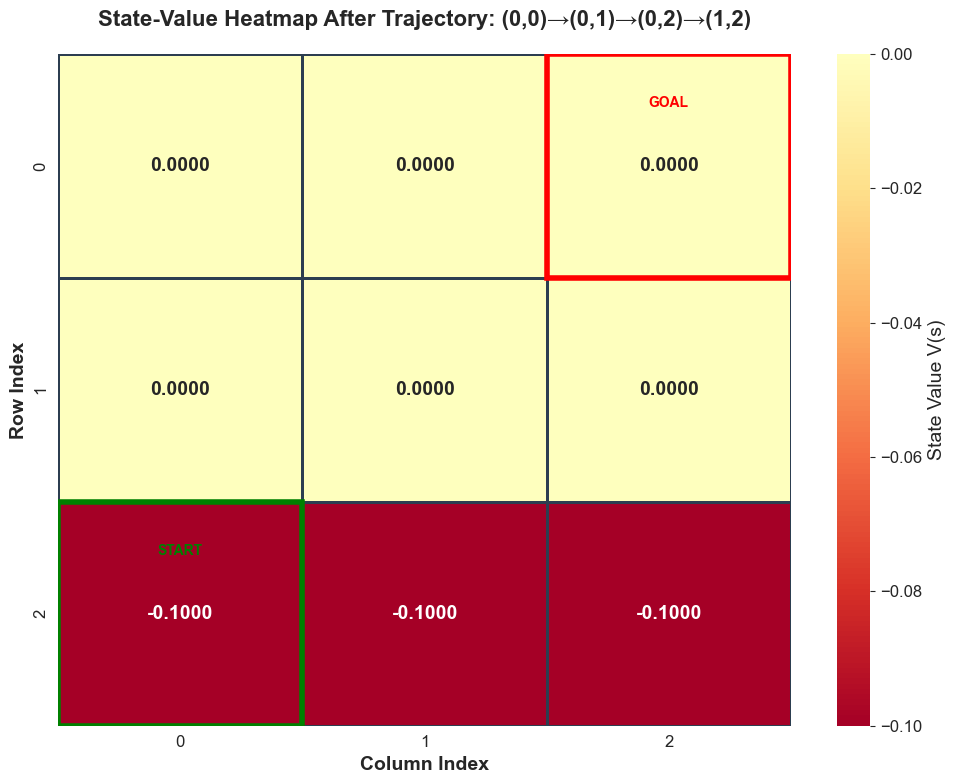

In [6]:
def plot_value_heatmap(V, title="State-Value Function V(s)"):
    """
    Generate a heatmap visualization of the value function.
    
    The heatmap provides intuitive understanding of which states
    have been updated and their relative values.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create heatmap with diverging colormap centered at zero
    # Negative values (penalties) show in cooler colors
    heatmap = sns.heatmap(V, annot=True, fmt='.4f', cmap='RdYlGn',
                          center=0, linewidths=2, linecolor='#2c3e50',
                          annot_kws={'size': 14, 'fontweight': 'bold'},
                          cbar_kws={'label': 'State Value V(s)'})
    
    # Mark special states
    ax.add_patch(plt.Rectangle((0, 2), 1, 1, fill=False, 
                                edgecolor='green', linewidth=4))
    ax.add_patch(plt.Rectangle((2, 0), 1, 1, fill=False, 
                                edgecolor='red', linewidth=4))
    
    ax.set_xlabel('Column Index', fontsize=14, fontweight='bold')
    ax.set_ylabel('Row Index', fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Annotation for special states
    ax.text(0 + 0.5, 2 + 0.22, 'START', ha='center', va='center',
            fontsize=10, color='green', fontweight='bold', zorder=10)
    ax.text(2 + 0.5, 0 + 0.22, 'GOAL', ha='center', va='center',
            fontsize=10, color='red', fontweight='bold', zorder=10)

    
    plt.tight_layout()
    plt.show()


# Display the V-values after the trajectory updates
# Flip V vertically for correct visual orientation (row 0 at bottom)
plot_value_heatmap(np.flipud(V), 
                   title="State-Value Heatmap After Trajectory: (0,0)→(0,1)→(0,2)→(1,2)")

### Trajectory Visualization on Grid

The following visualization overlays the simulated trajectory on the grid, showing the path taken and the direction of each transition. This provides spatial context for understanding which states were updated during the simulation.

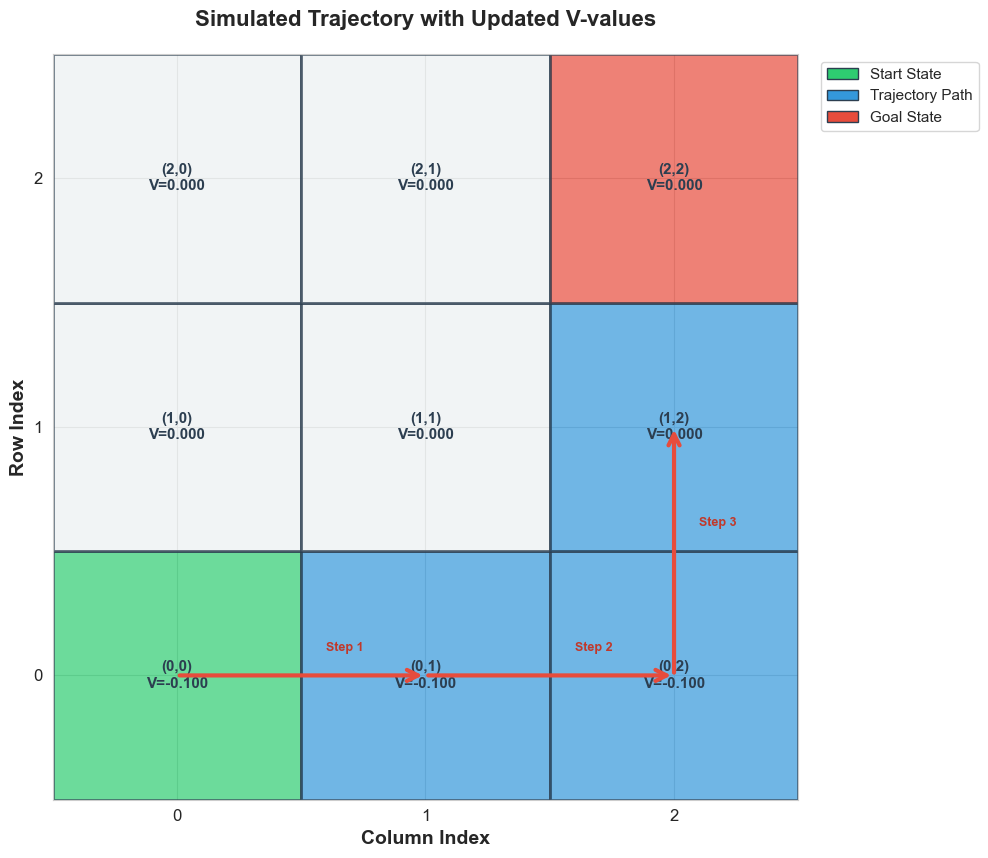

In [7]:
def visualize_trajectory(env, trajectory, V):
    """
    Visualize the trajectory overlaid on the grid with value annotations.
    
    This combined view shows both the spatial path and resulting value updates.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    colors = {
        'start': '#2ecc71',
        'goal': '#e74c3c',
        'normal': '#ecf0f1',
        'path': '#3498db'
    }
    
    # Collect states in trajectory for highlighting
    path_states = set()
    for state, _, next_state, _ in trajectory:
        path_states.add(state)
        path_states.add(next_state)
    
    # Draw grid cells
    for row in range(env.grid_size):
        for col in range(env.grid_size):
            state = (row, col)
            
            if state == env.start_state:
                color = colors['start']
            elif state == env.goal_state:
                color = colors['goal']
            elif state in path_states:
                color = colors['path']
            else:
                color = colors['normal']
            
            rect = plt.Rectangle((col, row), 1, 1, 
                                  facecolor=color, 
                                  edgecolor='#2c3e50', 
                                  linewidth=2,
                                  alpha=0.7)
            ax.add_patch(rect)
            
            # Display state coordinates and V-value
            value_text = f'({row},{col})\nV={V[row,col]:.3f}'
            ax.text(col + 0.5, row + 0.5, value_text, 
                    ha='center', va='center', 
                    fontsize=11, fontweight='bold',
                    color='#2c3e50')
    
    # Draw trajectory arrows
    for i, (state, action, next_state, reward) in enumerate(trajectory):
        start_x = state[1] + 0.5
        start_y = state[0] + 0.5
        end_x = next_state[1] + 0.5
        end_y = next_state[0] + 0.5
        
        # Draw arrow along trajectory
        ax.annotate('', xy=(end_x, end_y), xytext=(start_x, start_y),
                    arrowprops=dict(arrowstyle='->', 
                                   color='#e74c3c',
                                   lw=3,
                                   mutation_scale=20))
        
        # Label the step number
        mid_x = (start_x + end_x) / 2
        mid_y = (start_y + end_y) / 2
        ax.text(mid_x + 0.1, mid_y + 0.1, f'Step {i+1}',
                fontsize=9, color='#c0392b', fontweight='bold')
    
    ax.set_xlim(0, env.grid_size)
    ax.set_ylim(0, env.grid_size)
    ax.set_aspect('equal')
    ax.set_xlabel('Column Index', fontsize=14, fontweight='bold')
    ax.set_ylabel('Row Index', fontsize=14, fontweight='bold')
    ax.set_title('Simulated Trajectory with Updated V-values', 
                 fontsize=16, fontweight='bold', pad=20)
    
    ax.set_xticks([0.5, 1.5, 2.5])
    ax.set_xticklabels(['0', '1', '2'])
    ax.set_yticks([0.5, 1.5, 2.5])
    ax.set_yticklabels(['0', '1', '2'])
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor=colors['start'], edgecolor='#2c3e50', 
                       label='Start State'),
        mpatches.Patch(facecolor=colors['path'], edgecolor='#2c3e50', 
                       label='Trajectory Path'),
        mpatches.Patch(facecolor=colors['goal'], edgecolor='#2c3e50', 
                       label='Goal State')
    ]
    ax.legend(handles=legend_elements, loc='upper left', 
              bbox_to_anchor=(1.02, 1), fontsize=11)
    
    plt.tight_layout()
    plt.show()


# Visualize the trajectory with updated values
visualize_trajectory(env, trajectory, V)

---

## 4. Critical Reflection (5 Marks)

### Bootstrapping (TD) vs. Monte Carlo (MC): A Comparative Analysis

The choice between Temporal-Difference and Monte Carlo methods for value function estimation involves trade-offs across multiple dimensions. This section provides a rigorous comparison.

#### Fundamental Distinctions

| Aspect | Temporal-Difference (TD) | Monte Carlo (MC) |
|--------|--------------------------|------------------|
| **Update Target** | $R + \gamma V(S')$ (bootstrap estimate) | $G_t$ (complete episodic return) |
| **Update Timing** | After each transition | After episode termination |
| **Bias** | Biased (depends on $V(S')$ accuracy) | Unbiased (uses true sample returns) |
| **Variance** | Lower (single-step randomness) | Higher (full trajectory randomness) |
| **Convergence** | Faster initial learning | Slower but asymptotically correct |

#### Why TD is Superior for the Christ University Navigation Robot

1. **Continuous Operation**: The robot must function during examination periods without the luxury of completing episodes before learning. TD enables immediate value updates after each corridor traversal.

2. **Dynamic Environment**: Campus conditions change (blocked paths, temporary obstacles). TD's single-step updates allow rapid adaptation, whereas MC would require completing navigation to the goal before incorporating new information.

3. **Real-Time Responsiveness**: Each step the robot takes generates a learning signal. This incremental feedback loop is essential for safe and responsive navigation.

4. **Failure Recovery**: If the robot's episode is interrupted (low battery, emergency stop), TD has already incorporated partial learning. MC would discard all experience from the incomplete trajectory.

5. **Bootstrapping Advantage**: Even with imperfect value estimates, TD can propagate reward signals efficiently through state space, enabling faster policy improvement.

In [8]:
# Construct a comprehensive comparison DataFrame
comparison_data = {
    'Criterion': [
        'Update Timing',
        'Update Frequency',
        'Bias',
        'Variance',
        'Episodic Requirement',
        'Convergence Speed',
        'Continuous Task Suitability',
        'Memory Requirement',
        'Partial Episode Utility'
    ],
    'Temporal-Difference (TD)': [
        'After each step',
        'High (every transition)',
        'Biased (bootstrap estimate)',
        'Low (single-step)',
        'Not required',
        'Fast (immediate updates)',
        'Excellent',
        'Minimal (O(1) per update)',
        'Full utilization'
    ],
    'Monte Carlo (MC)': [
        'After episode ends',
        'Low (once per episode)',
        'Unbiased (true returns)',
        'High (full trajectory)',
        'Strictly required',
        'Slow (waits for termination)',
        'Poor',
        'High (store full episode)',
        'Complete loss'
    ]
}

df_comparison = pd.DataFrame(comparison_data)

# Display the formatted comparison table
print("=" * 90)
print("TEMPORAL-DIFFERENCE vs MONTE CARLO: COMPREHENSIVE COMPARISON")
print("=" * 90)
print()

# Set display options for better formatting
pd.set_option('display.max_colwidth', 40)
pd.set_option('display.width', 200)

print(df_comparison.to_string(index=False))

TEMPORAL-DIFFERENCE vs MONTE CARLO: COMPREHENSIVE COMPARISON

                  Criterion    Temporal-Difference (TD)             Monte Carlo (MC)
              Update Timing             After each step           After episode ends
           Update Frequency     High (every transition)       Low (once per episode)
                       Bias Biased (bootstrap estimate)      Unbiased (true returns)
                   Variance           Low (single-step)       High (full trajectory)
       Episodic Requirement                Not required            Strictly required
          Convergence Speed    Fast (immediate updates) Slow (waits for termination)
Continuous Task Suitability                   Excellent                         Poor
         Memory Requirement   Minimal (O(1) per update)    High (store full episode)
    Partial Episode Utility            Full utilization                Complete loss


### Visual Comparison: Update Frequency

The following visualization contrasts the update patterns of TD and MC methods across a typical 10-step episode. TD updates occur at every timestep, while MC waits until episode completion. This fundamental difference in learning dynamics explains TD's advantage in continuous environments.

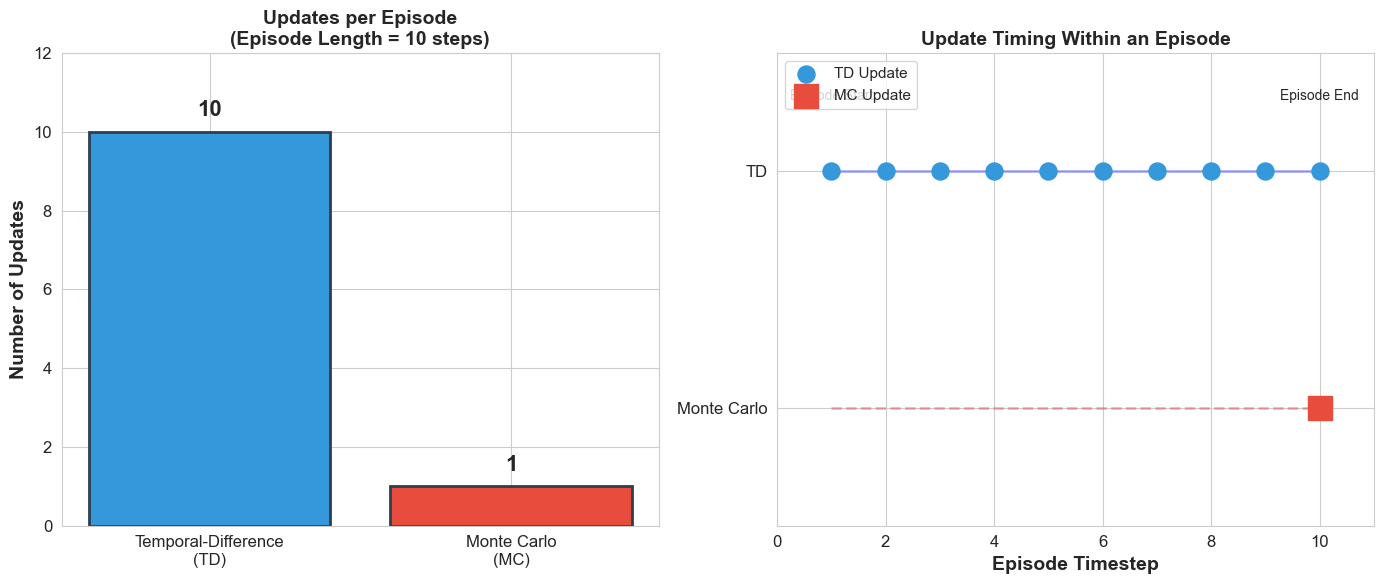

In [9]:
def plot_update_frequency_comparison():
    """
    Visualize the fundamental difference in update timing between TD and MC methods.
    
    This bar chart demonstrates why TD is preferred for continuous learning:
    it provides learning signals at every step rather than waiting for episode end.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Subplot 1: Update frequency per step
    ax1 = axes[0]
    methods = ['Temporal-Difference\n(TD)', 'Monte Carlo\n(MC)']
    
    # Assume a 10-step episode for illustration
    episode_length = 10
    td_updates = episode_length  # TD updates at every step
    mc_updates = 1               # MC updates once at episode end
    
    updates = [td_updates, mc_updates]
    colors = ['#3498db', '#e74c3c']
    
    bars = ax1.bar(methods, updates, color=colors, edgecolor='#2c3e50', linewidth=2)
    
    ax1.set_ylabel('Number of Updates', fontsize=14, fontweight='bold')
    ax1.set_title(f'Updates per Episode\n(Episode Length = {episode_length} steps)', 
                  fontsize=14, fontweight='bold')
    ax1.set_ylim(0, 12)
    
    # Add value annotations on bars
    for bar, val in zip(bars, updates):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f'{val}', ha='center', va='bottom', fontsize=16, fontweight='bold')
    
    # Subplot 2: Timeline visualization
    ax2 = axes[1]
    
    steps = list(range(1, episode_length + 1))
    
    # TD: updates at every step (represented by markers)
    ax2.scatter(steps, [2] * episode_length, s=150, c='#3498db', 
                marker='o', label='TD Update', zorder=3)
    ax2.plot([1, episode_length], [2, 2], 'b-', alpha=0.3, linewidth=2)
    
    # MC: single update at episode end
    ax2.scatter([episode_length], [1], s=300, c='#e74c3c', 
                marker='s', label='MC Update', zorder=3)
    ax2.plot([1, episode_length], [1, 1], 'r--', alpha=0.3, linewidth=2)
    
    ax2.set_xlabel('Episode Timestep', fontsize=14, fontweight='bold')
    ax2.set_title('Update Timing Within an Episode', fontsize=14, fontweight='bold')
    ax2.set_yticks([1, 2])
    ax2.set_yticklabels(['Monte Carlo', 'TD'])
    ax2.set_xlim(0, episode_length + 1)
    ax2.set_ylim(0.5, 2.5)
    ax2.legend(loc='upper left', fontsize=11)
    
    # Add annotations
    ax2.annotate('Episode Start', xy=(1, 2.3), fontsize=10, ha='center')
    ax2.annotate('Episode End', xy=(episode_length, 2.3), fontsize=10, ha='center')
    
    plt.tight_layout()
    plt.show()


# Generate the update frequency comparison visualization
plot_update_frequency_comparison()

### Bias-Variance Trade-off Visualization

A key consideration when choosing between TD and MC is the bias-variance trade-off. TD methods exhibit lower variance but introduce bias through bootstrapping, while MC methods are unbiased but suffer from high variance due to full-trajectory sampling.

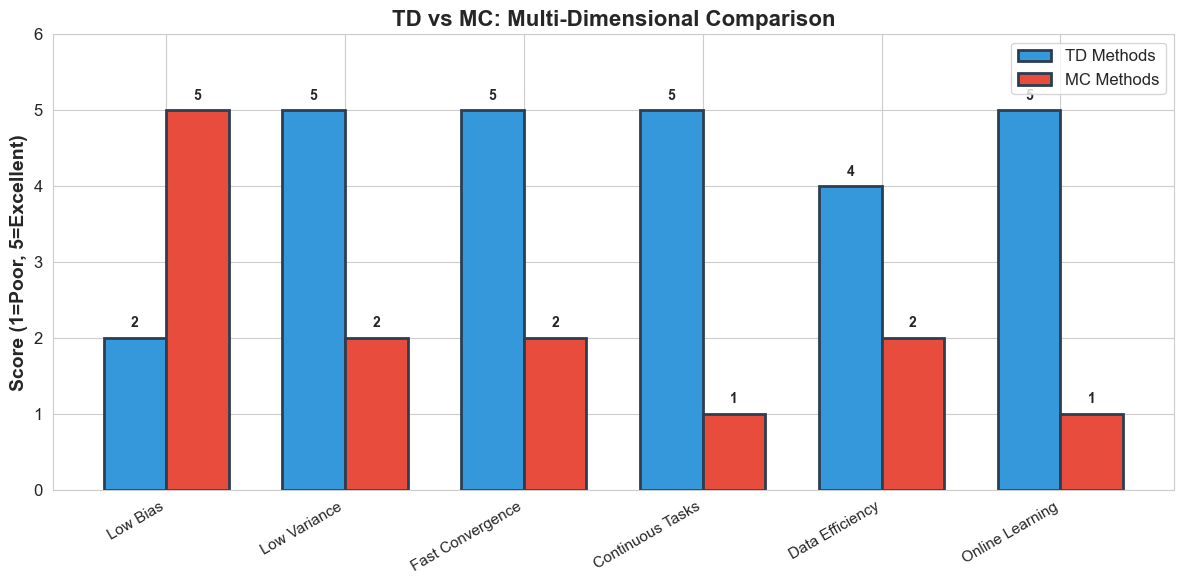

In [10]:
def plot_bias_variance_tradeoff():
    """
    Visualize the bias-variance characteristics of TD vs MC methods.
    
    This radar/comparison chart highlights the complementary strengths
    and weaknesses of each approach across multiple evaluation dimensions.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Define comparison metrics (scale 1-5 for visualization)
    categories = ['Low Bias', 'Low Variance', 'Fast Convergence', 
                  'Continuous Tasks', 'Data Efficiency', 'Online Learning']
    
    # Scores for each method (subjective but based on theoretical properties)
    td_scores = [2, 5, 5, 5, 4, 5]  # TD: biased but low variance, excellent online
    mc_scores = [5, 2, 2, 1, 2, 1]  # MC: unbiased but high variance, poor online
    
    x = np.arange(len(categories))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, td_scores, width, label='TD Methods', 
                   color='#3498db', edgecolor='#2c3e50', linewidth=2)
    bars2 = ax.bar(x + width/2, mc_scores, width, label='MC Methods', 
                   color='#e74c3c', edgecolor='#2c3e50', linewidth=2)
    
    ax.set_ylabel('Score (1=Poor, 5=Excellent)', fontsize=14, fontweight='bold')
    ax.set_title('TD vs MC: Multi-Dimensional Comparison', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=30, ha='right', fontsize=11)
    ax.set_ylim(0, 6)
    ax.legend(fontsize=12)
    
    # Add score annotations
    for bar in bars1:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{int(bar.get_height())}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')
    for bar in bars2:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{int(bar.get_height())}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


# Generate the comparison chart
plot_bias_variance_tradeoff()

### Conclusion: TD Supremacy for Campus Navigation

For the Christ University Central Block navigation robot, Temporal-Difference learning with bootstrapping presents clear advantages:

1. **Immediate Learning**: Each step through the corridors generates a learning signal, allowing continuous policy refinement.

2. **Robustness to Interruption**: Incomplete episodes (battery depletion, emergency stops) still contribute to learning.

3. **Adaptive Responsiveness**: Dynamic environmental changes (exam schedules, crowd density) can be incorporated in real-time.

4. **Computational Efficiency**: No need to store complete trajectories; updates require only $O(1)$ memory per step.

While TD methods introduce estimation bias through bootstrapping, this trade-off is acceptable given the operational requirements of a campus navigation system that must learn and adapt continuously during examination periods.

In [11]:
# Summary visualization: Final recommendation
print("=" * 70)
print("FINAL RECOMMENDATION")
print("=" * 70)
print("""
For the Christ University Central Block navigation robot:

╔════════════════════════════════════════════════════════════════════╗
║                                                                    ║
║    RECOMMENDED METHOD: TEMPORAL-DIFFERENCE (TD) LEARNING           ║
║                                                                    ║
║    Key Justifications:                                             ║
║    • Enables learning during continuous operation                  ║
║    • Adapts immediately to environmental changes                   ║
║    • Does not require episode completion for updates               ║
║    • Lower variance leads to more stable learning                  ║
║    • Computationally efficient for real-time deployment            ║
║                                                                    ║
╚════════════════════════════════════════════════════════════════════╝
""")

# Final summary table
final_summary = pd.DataFrame({
    'Aspect': ['Primary Method', 'Update Equation', 'Learning Mode', 'Campus Suitability'],
    'Specification': [
        'TD(0) with Bootstrapping',
        'V(S) ← V(S) + α[R + γV(S\') - V(S)]',
        'Online, Incremental',
        'Optimal for dynamic campus environment'
    ]
})

print("\nImplementation Summary:")
print(final_summary.to_string(index=False))

FINAL RECOMMENDATION

For the Christ University Central Block navigation robot:

╔════════════════════════════════════════════════════════════════════╗
║                                                                    ║
║    RECOMMENDED METHOD: TEMPORAL-DIFFERENCE (TD) LEARNING           ║
║                                                                    ║
║    Key Justifications:                                             ║
║    • Enables learning during continuous operation                  ║
║    • Adapts immediately to environmental changes                   ║
║    • Does not require episode completion for updates               ║
║    • Lower variance leads to more stable learning                  ║
║    • Computationally efficient for real-time deployment            ║
║                                                                    ║
╚════════════════════════════════════════════════════════════════════╝


Implementation Summary:
            Aspect                       